In [142]:
import matplotlib as mplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import os

In [143]:
def compute_distances_single_row(row, number):
    row_values = row.astype(int)                # Convert the row values to integers
    indices = np.where(row_values == number)[0] # Find the indices where the number occurs in the row
    distances = np.diff(indices)                # Compute the distances between consecutive occurrences
    return distances.tolist()


def compute_all_distances(log_dict):                # compute distances for all runs
    gap_dict={}                                     # stores all gaps
    dev_dict={}                                     # stores deviations from 'fair gap'
    thread_configs=list(log_dict)                   # list of N_iouter_iiter configurations

    for config in thread_configs:
        gaps = []
        data_df = log_dict[config]
        meta_data = re.findall(r'\d+', config)
        meta_data= list(map(int, meta_data))
        #meta_data = [int(s) for s in config.split() if s.isdigit()]
        n_threads = meta_data[0]
        outer_iter = meta_data[1]
        inner_iter = meta_data[2]

        fair_case = inner_iter / n_threads          # fairest scenario: (#inner_iterations / #threads) lock acquisitions per thread
        deviations = []                             # deviation from fairest scenario per outer iteration
        
        for run in range(outer_iter):
            # print("run:", run)
            for thread_id in range(n_threads):
                #print("tid:", thread_id, compute_distances_single_row(data_df.iloc[run], thread_id))
                distances = compute_distances_single_row(data_df.iloc[run], thread_id)
                gaps = gaps + distances
                deviations.append(abs(fair_case - len(distances)))
        
        dev_dict[config]=deviations
        gap_dict[config]=list((np.array(gaps) /n_threads))
    return dev_dict, gap_dict
            

def compute_max_min_distances(df, n_threads):   # do we need this?
    min_distances = []
    max_distances = []

    for index, row in df.iterrows(): #loop through all outer loops
        row_values = row.astype(int)
        
        min_dist = np.nan                               # Initialize min/max dist
        max_dist = np.nan                               # Initialize min/max dist
        
        for num in range(n_threads):                    # iterate thorufh all threads
            indices = np.where(row_values == num)[0]    # Find the indices where the number occurs in the row
            if len(indices) >= 2:                       # Compute the distances between consecutive occurrences and update min/max dist
                distances = np.diff(indices)    
                min_dist = np.nanmin(distances) if np.isnan(min_dist) else min(min_dist, np.nanmin(distances))
                max_dist = np.nanmax(distances) if np.isnan(max_dist) else max(max_dist, np.nanmax(distances))
        
        min_distances.append(min_dist)                  # Append min/max dist to the respective lists
        max_distances.append(max_dist)

    df['min_gap'] = min_distances                       # Add min/max dist as new columns in the DataFrame
    df['max_gap'] = max_distances
    return df


In [144]:
# LOAD FAIRNESS DATA FROM DIFFERENT LOCKS

'''
fairness_flock_N_oiter_iter.txt            lock-filter with N threads, oiter outer iterations, iiter inner iterations
fairness_bwoo_N....txt                     block-woo
fairness_binary_N....txt                   torunament-tree
fairness_alag_N....txt                     alagarsamy
'''
# find .txt files in sub dirs
data_src=glob.glob(os.getcwd()+"/*/*.txt")

fairness_dict= {}

for src in data_src:
    lock_dict={}
    data=[]
    with open(src, 'r') as file:
        lines = file.readlines()[2:]

        for line in lines:
            values = line.split()
            data.append(values)
        
        data = pd.DataFrame(data)
        lock_dict = data
        
        new_key=src.split("/")[-1][:-len('.txt')] # ignore path and suffix
        fairness_dict[new_key]=lock_dict

In [145]:
list(fairness_dict)

['fairness_test_8_10_100']

In [146]:
# EXAMPLE COMPUTE_DISTANCES
test_df= fairness_dict["fairness_test_8_10_100"]

iter_id = 0                                    # Specify the row index you want to compute distances for
th_id = 3                                      # Specify the number ID you want to compute distances for

row = test_df.iloc[iter_id]                    # Get the row based on the index
distances = compute_distances_single_row(row, th_id)      # Compute the distances for the given number in the row

print(f"Distances for number {th_id} in row {iter_id}:")
print(distances)

Distances for number 3 in row 0:
[6, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7]


Text(0.5, 1.0, 'The commonness of idleness-interval-lenghts (relative to thread count) for different locks ')

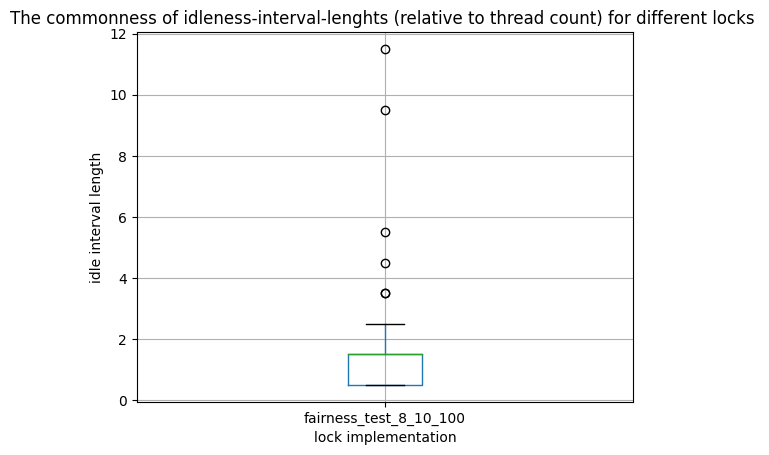

In [147]:
# EXAMPLE COMPUTE_DISTANCES FOR ALL DATA
dev_dict, gap_dict = compute_all_distances(fairness_dict)
dev_keys=list(dev_dict)
gap_keys=list(gap_dict)

dev_df=pd.DataFrame(dev_dict)
fig, ax1 = plt.subplots()
ax1 = dev_df.boxplot(figsize=(15,5), grid=True)
ax1.set_ylabel("idle interval length")
ax1.set_xlabel("lock implementation")
ax1.set_title("The commonness of idleness-interval-lenghts (relative to thread count) for different locks ")

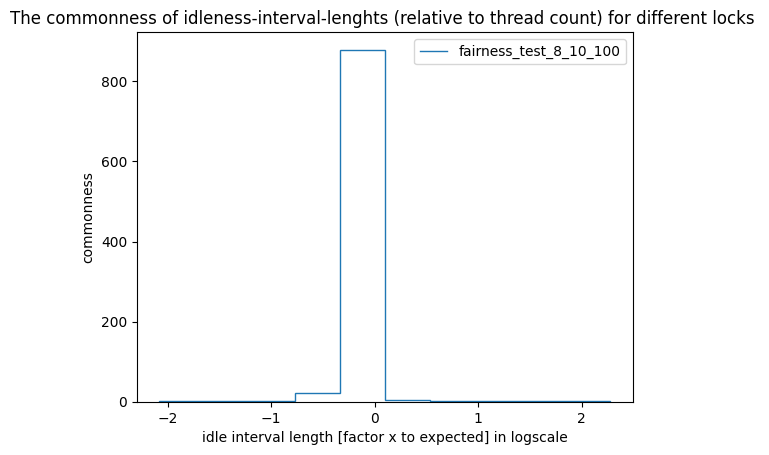

In [148]:
for key in gap_keys:
    gaps= gap_dict[key] 
    counts, bins = np.histogram(np.log(np.array(gaps)),density=False)
    plt.stairs(counts,bins,label=key)
    plt.legend()
    plt.xlabel("idle interval length [factor x to expected] in logscale")
    plt.ylabel("commonness")
    plt.title("The commonness of idleness-interval-lenghts (relative to thread count) for different locks ")
    # plt.hist(gaps, bins=range(min(gaps), max(gaps)+2))